<a href="https://colab.research.google.com/github/jdmartinev/ArtificialIntelligenceIM/blob/main/Lecture11/notebooks/L11_DeepQNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium[atari]
!pip install gymnasium[accept-rom-license]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 17.8 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade gymnasium[atari,accept-rom-license]

In [ ]:
!pip uninstall gymnasium ale-py
!pip install gymnasium[atari,accept-rom-license]

Found existing installation: gymnasium 1.0.0
Uninstalling gymnasium-1.0.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/gymnasium-1.0.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/gymnasium/*
Proceed (Y/n)? Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/uninstall.py", line 106, in run
    uninstall_pathset = req.uninstall(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_install.py", line 722, in uninstall
    uninstalled_pathset.remove(auto_confirm, verbose)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_uninstall.py", line 364, in remove
    if auto_confirm or self._allowed_to_proceed(verbose):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_uninstall.py", line 404, in _allowed_to_proceed
  

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras import layers
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing, FrameStackObservation
import numpy as np
import tensorflow as tf
from gymnasium.wrappers import RecordVideo
import matplotlib.pyplot as plt

In [ ]:
print(gym.envs.registry.keys())

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'phys2d/CartPole-v0', 'phys2d/CartPole-v1', 'phys2d/Pendulum-v0', 'LunarLander-v3', 'LunarLanderContinuous-v3', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v3', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'tabular/Blackjack-v0', 'tabular/CliffWalking-v0', 'Reacher-v2', 'Reacher-v4', 'Reacher-v5', 'Pusher-v2', 'Pusher-v4', 'Pusher-v5', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedPendulum-v5', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'InvertedDoublePendulum-v5', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'HalfCheetah-v5', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Hopper-v5', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Swimmer-v5', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Walker2d-v5', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Ant-v5', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'Humanoid-v5

In [ ]:
# Configuration parameters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 10000
max_episodes = 10000  # Limit training episodes, will run until solved if smaller than 1

# Use the Atari environment
env = gym.make("BreakoutNoFrameskip-v4", render_mode="rgb_array")

env.seed = seed

# Environment preprocessing
env = AtariPreprocessing(env)

# Stack four frames
env = FrameStackObservation(env, 4)

In [ ]:
num_actions = 4

def create_q_model(num_actions):
    # Network defined by the Deepmind paper
    return keras.Sequential(
        [
            # Input layer to specify the shape
            keras.Input(shape=(4,84, 84)),
            # Transpose layer to adjust the input shape from (4, 84, 84) to (84, 84, 4)
            layers.Lambda(lambda tensor: tf.transpose(tensor, [0, 2, 3, 1])),
            # Convolutions on the frames on the screen
            layers.Conv2D(32, 8, strides=4, activation="relu"),
            layers.Conv2D(64, 4, strides=2, activation="relu"),
            layers.Conv2D(64, 3, strides=1, activation="relu"),
            layers.Flatten(),
            layers.Dense(512, activation="relu"),
            layers.Dense(num_actions, activation="linear"),
        ]
    )

# The first model makes the predictions for Q-values which are used to
# make a action.
model = create_q_model(num_actions)
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = create_q_model(num_actions)


In [ ]:
# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 50000
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 100000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 10000
# Using huber loss for stability
loss_function = keras.losses.Huber()

while True:
    observation, _ = env.reset()
    state = np.array(observation)
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = keras.ops.convert_to_tensor(state)
            state_tensor = keras.ops.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = keras.ops.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        state_next, reward, done, _, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:
            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = keras.ops.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * keras.ops.amax(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = keras.ops.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = keras.ops.sum(keras.ops.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if running_reward > 40:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

    if (
        max_episodes > 0 and episode_count >= max_episodes
    ):  # Maximum number of episodes reached
        print("Stopped at episode {}!".format(episode_count))
        break

Se han truncado las últimas 5000 líneas del flujo de salida.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

1
0.0
3
0.0
2
0.0
1
0.0
0
0.0
3
0.0
2
0.0
2
0.0
1
0.0
3
0.0
3
0.0
0
0.0
0
0.0
3
0.0
2
0.0
0
0.0
1
0.0
2
0.0
2
0.0
0
0.0
2
0.0
2
0.0
2
0.0
2
0.0
2
0.0
0
0.0
2
0.0
1
0.0
3
0.0
1
0.0
3
0.0
2
0.0
1
0.0
0
0.0
1
0.0
0
0.0
2
0.0
1
0.0
2
0.0
2
0.0
1
0.0
0
0.0
3
0.0
0
0.0
3
0.0
2
0.0
2
0.0
3
0.0
0
0.0
0
0.0
2
0.0
2
0.0
2
0.0
0
0.0
0
0.0
1
0.0
0
0.0
0
0.0
1
0.0
0
0.0
1
0.0
0
0.0
3
0.0
0
0.0
0
0.0
0
0.0
2
0.0
0
0.0
2
0.0
1
0.0
1
0.0
1
0.0
2
0.0
0
0.0
3
0.0
3
0.0
3
0.0
1
0.0
0
0.0
1
0.0
3
0.0
2
0.0
3
0.0
2
0.0
3
0.0
2
0.0
3
0.0
1
0.0
1
0.0
3
0.0
0
0.0
0
0.0
2
0.0
3
0.0
2
0.0
3
0.0
2
0.0
1
0.0
2
0.0
1
0.0
2
0.0
0
0.0
0
0.0
2
0.0
2
0.0
1
0.0
1
0.0
2
0.0
3
0.0
1
0.0
3
0.0
3
0.0
3
0.0
3
0.0
1
0.0
1
0.0
2
0.0
1
0.0
2
0.0
0
0.0
0
0.0
1
0.0
2
0.0
2
0.0
3
0.0
1
0.0
0
0.0
2
0.0
3
0.0
0
0.0


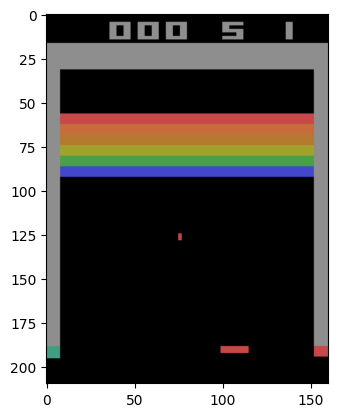

In [ ]:
# Initialize variables
observation, _ = env.reset()
state = np.array(observation)
frames = []
episode_reward = 0

while True:
    # Get action probabilities from the model
    state_tensor = keras.ops.convert_to_tensor(state)
    state_tensor = keras.ops.expand_dims(state_tensor, 0)
    action_probs = model(state_tensor, training=False)
    # Take best action
    action = keras.ops.argmax(action_probs[0]).numpy()
    action = np.random.randint(0, num_actions)
    # Step the environment
    state, reward, done, truncated, info = env.step(action)
    state = np.array(state)
    episode_reward += reward

    frames.append(env.render())

    if done or truncated:
        break

env.close()

# Example: Display one of the captured frames using matplotlib
if frames:
    plt.imshow(frames[0])
    plt.show()
else:
    print("No frames were captured.")

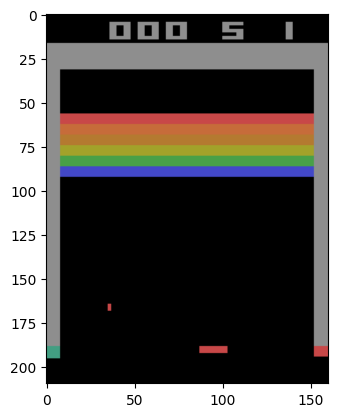

In [ ]:
# Example: Display one of the captured frames using matplotlib
if frames:
    plt.imshow(frames[10])
    plt.show()
else:
    print("No frames were captured.")


In [ ]:
import imageio

# Save frames as a video
with imageio.get_writer("breakout_play_1.mp4", fps=30) as video_writer:
    for frame in frames:
        video_writer.append_data(frame)